In [3]:
import os
import sys
import torch
import matplotlib.pyplot as plt
from torch.utils.data._utils.collate import default_collate
import math 

cwd = os.getcwd()
sys.path.append(os.path.dirname(os.path.dirname(cwd)))

In [4]:
plt.rcdefaults()

In [5]:
from torch.utils.data import DataLoader

from src.utils.plot_timeline import plot_timeline, get_trailer_colors
from src.utils import load_model
from src.problems import EVRP

In [6]:
# model, _ = load_model('../../outputs/evrp_4/rollout_20230614T160835') # with lots of batches and normal cost
# model, _ = load_model('../../outputs/evrp_4/rollout_20230614T160732') # with cost and lots of batches
# model, _ = load_model('../../outputs/evrp_4/rollout_20230617T040439') # new
# model, _ = load_model('../../pretrained/evrp') # pretrained
# model, _ = load_model('../../outputs/evrp_5/rollout_20230720T022239') 
# model, _ = load_model('../../outputs/evrp_5/rollout_20230720T132105') # model to compare with the other epochs 18
# model, _ = load_model('../../outputs/evrp_5/rollout_20230725T213940') # model to compare with the other epochs 30 without extra costs
# model, _ = load_model('../../outputs/evrp_5/rollout_20230803T184242') # changed cost function model to compare
# model, _ = load_model('../../runs/evrp_5/rollout_20230812T213543') # 
# "batch_size": 512,
#   "hyperparameter_tuning": true,
#   "lr_model": 3.615266142324226e-05,
#   "n_encode_layers": 3,
#   "n_epochs": 32,
#   "optimizer_class": "NAdam"
# model, _ = load_model('../../runs/evrp_5/rollout_20230814T133518') # changed cost function model to compare (normal reward func)

model, _ = load_model('../model') # changed cost function model to compare (normal reward func) / NAdam

model.eval()  # Put in evaluation mode to not track gradients

  [*] Loading model from ../model/epoch-50.pt


AttentionEVRPModel(
  (init_embed_node): Linear(in_features=5, out_features=128, bias=True)
  (project_node_embeddings): Linear(in_features=128, out_features=384, bias=False)
  (project_fixed_context): Linear(in_features=128, out_features=128, bias=False)
  (encoder): GraphAttentionEncoder(
    (layers): ModuleList(
      (0-2): 3 x MultiHeadAttentionLayer(
        (attention): SkipConnection(
          (module): MultiHeadAttention()
        )
        (bn1): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (bn2): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (ff): SkipConnection(
          (module): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
          )
        )
      )
    )


In [7]:
def collate_fn(batch):
    data_batch, graph_batch = zip(*batch)

    return default_collate(data_batch), list(graph_batch)


In [8]:
def tensor_to_tuples(tensor):
    batch_size, features, time = tensor.shape
    edges = []
    for b in range(batch_size):
        batch_list = tuple(tensor[b, :, time - 1].tolist())
        edges.append([batch_list])

    return edges

### Run Examples

Length:  tensor(7.0355) Penalty:  tensor(0., dtype=torch.float64)
Reward:  tensor(2.2502, dtype=torch.float64)


/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(block, ignore_index=True)
/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(block, ignore_index=True)
/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(block, ignore_index=True)
/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline

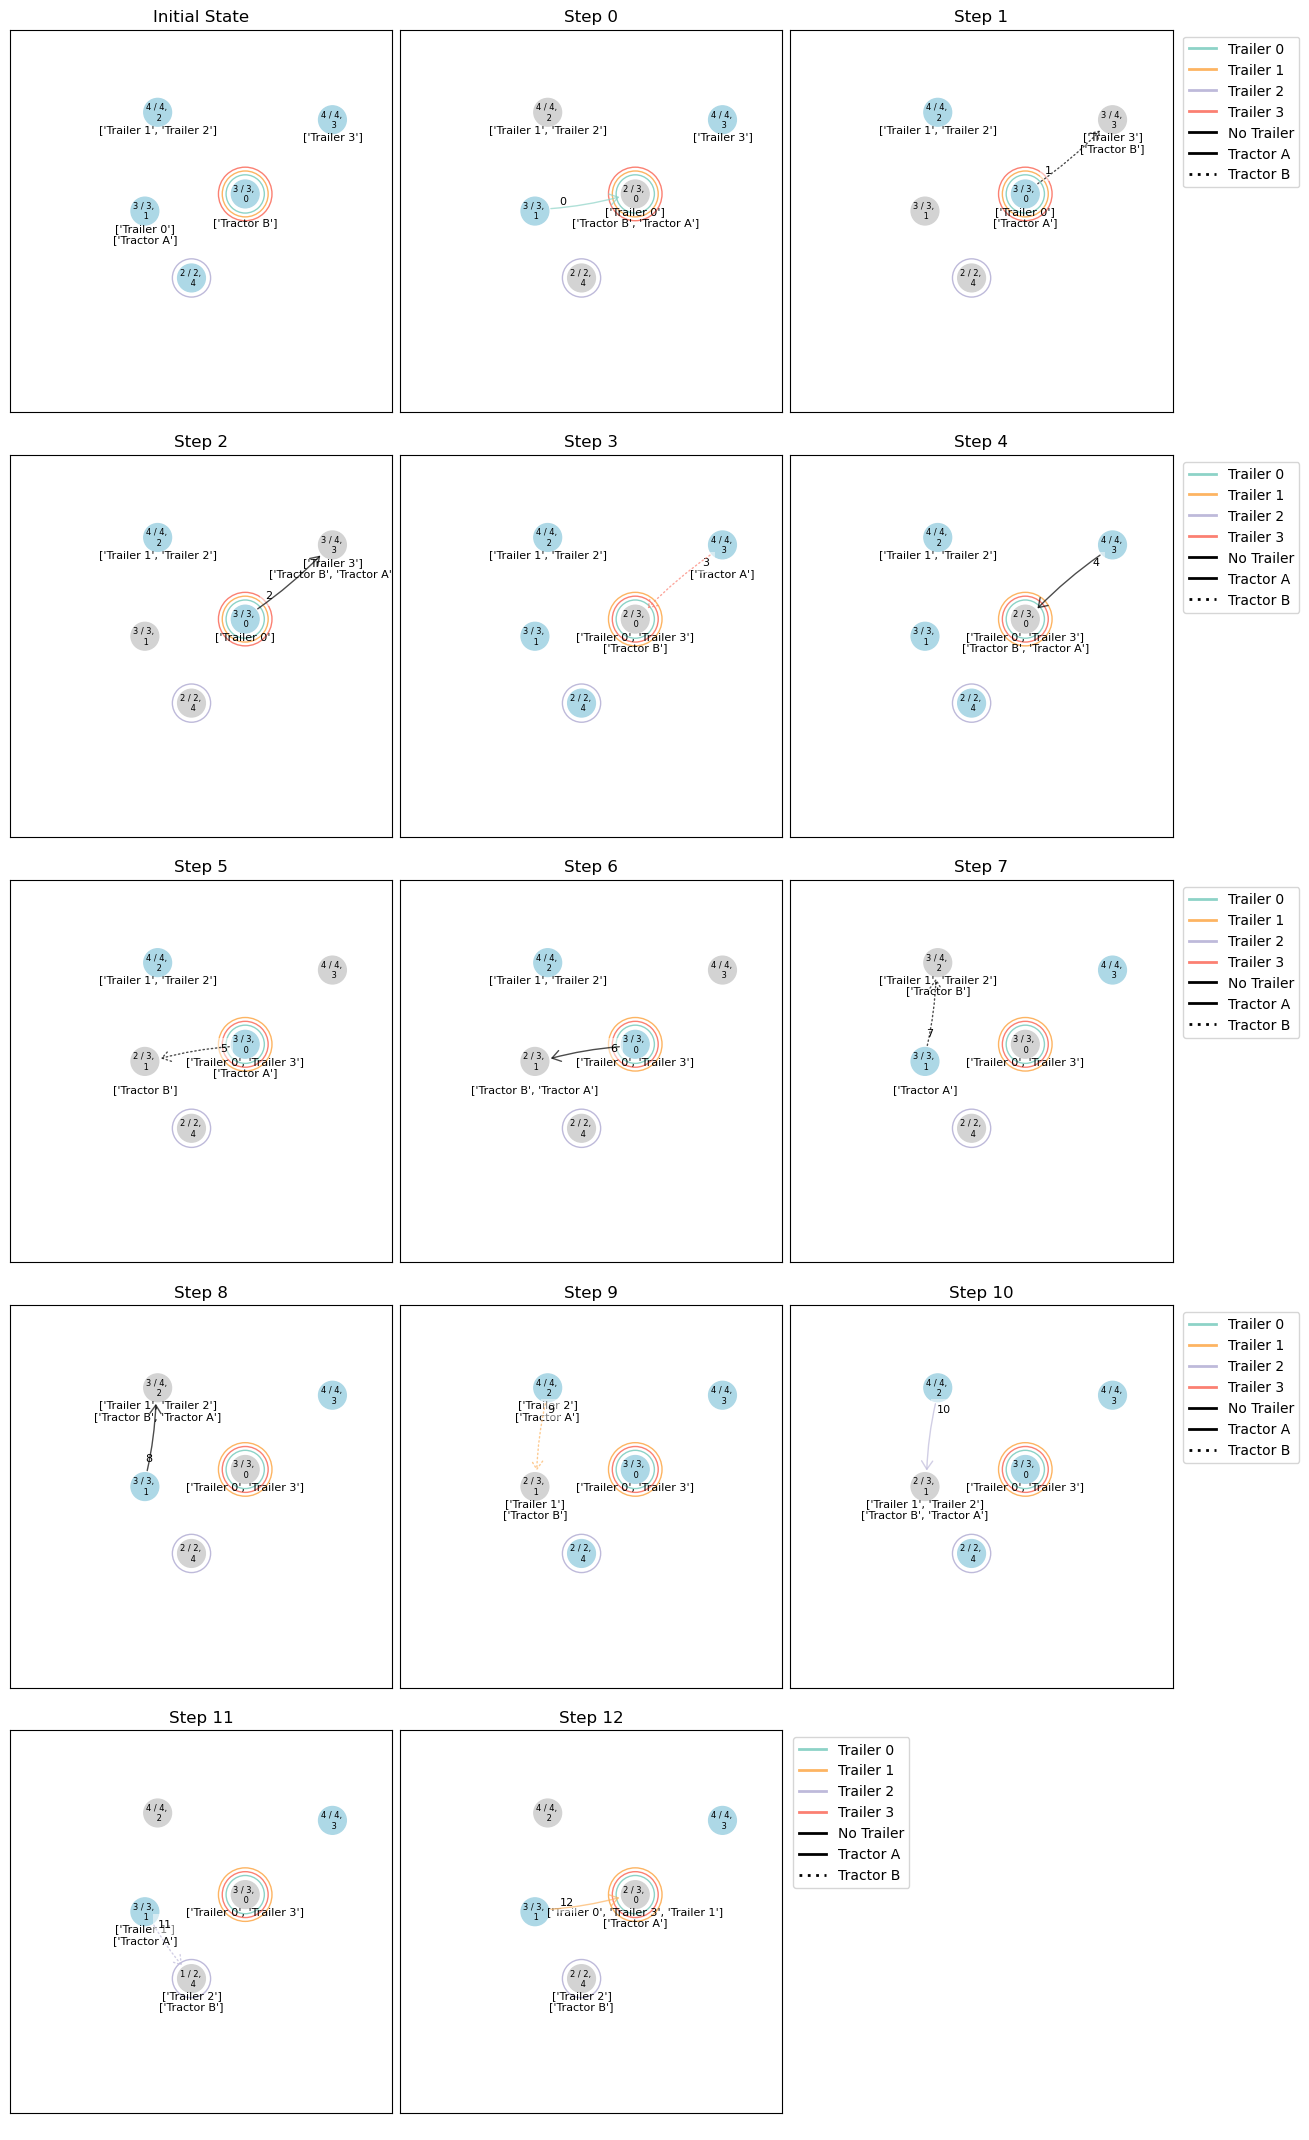

In [9]:
env = EVRP
val_dataset = env.make_dataset(
        size=5,
        num_samples=1,
        num_trucks=2,
        num_trailers=4,
        truck_names=None,
        display_graphs=3,
        r_threshold=0.6
    )

# Need a dataloader to batch instances
dataloader = DataLoader(val_dataset, batch_size=1, collate_fn=collate_fn)

# Make var works for dicts
batch_random = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')

with torch.no_grad():
    cost, length, reward, penalty, _, edges, decision = model(batch_random[0].copy(), batch_random[1].copy(), return_pi=True)

edges_random=edges.permute(1,2,0)
decision_random=decision.permute(0, 2, 1)

for i, graph in enumerate(batch_random[1]):
    edge_count = len(edges_random[i]) + 1

    cols = 3
    rows = math.ceil(edge_count / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5.5))  # Adjusted figure size
    plt.subplots_adjust(wspace=0.02, hspace=0.02)

    # Flatten axs to easily iterate over it
    axs = axs.ravel()

    graph.draw(ax=axs[0], with_labels=False)
    axs[0].set_title("Initial State")
    axs[0].set_xlim([-0.7, 1.3])
    axs[0].set_ylim([-0.7, 1.3])
    axs[0].set_aspect('equal')

    col = 1
    for edge, d in zip(edges_random[i], decision_random[i]):

        graph.clear()
        graph.visit_edges([edge])
        graph.draw(ax=axs[col], with_labels=True)
        axs[col].set_title(f"Step {col-1}")
        axs[col].set_xlim([-0.7, 1.3])
        axs[col].set_ylim([-0.7, 1.3])
        axs[col].set_aspect('equal')

        col += 1

    data_edges = edges_random[i].numpy().astype(int)
    plot_timeline(data_edges)

# Hide empty subplots
for j in range(col, len(axs)):
    axs[j].axis('off')

plt.show()
plt.close()

Length:  tensor(3.7343) Penalty:  tensor(0., dtype=torch.float64)
Reward:  tensor(0.8463, dtype=torch.float64)


/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:73: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:73: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:73: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:73: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

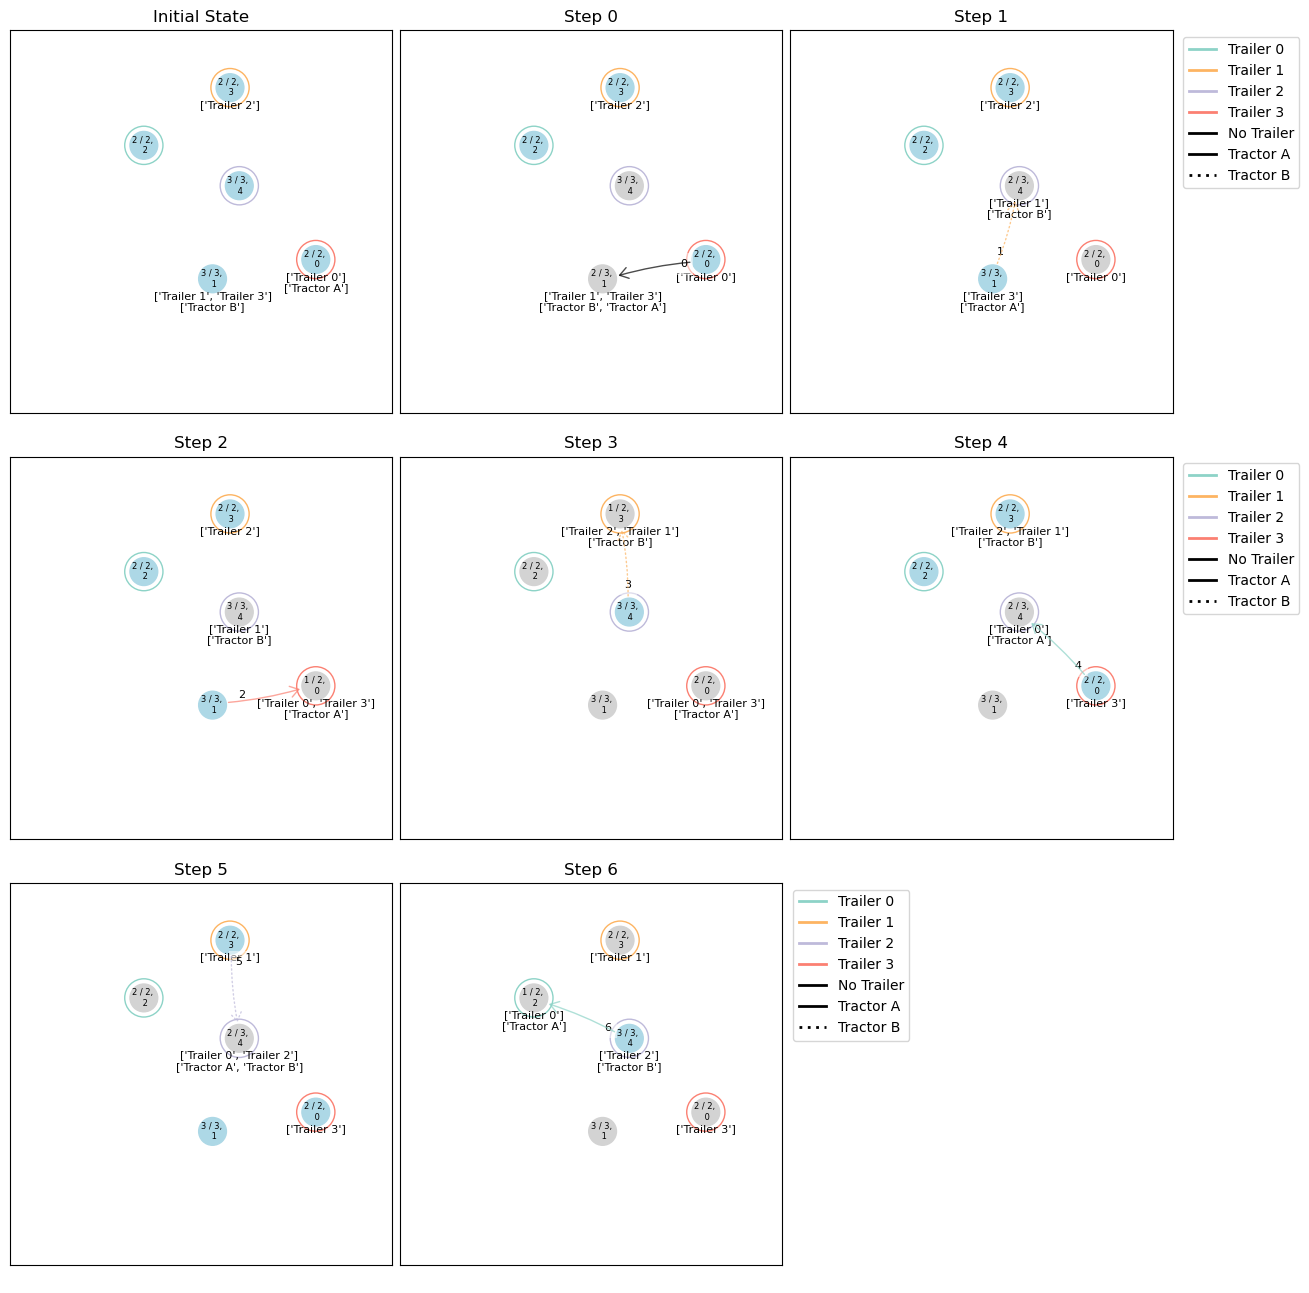

In [10]:
env = EVRP
dataset = env.make_dataset(
        filename='../instances/paper_5_nodes_swapping.json',
        r_threshold=0.6
    )
example_name="paper5"

# Need a dataloader to batch instances
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)

# Make var works for dicts
batch = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')

with torch.no_grad():
    cost, length, reward, penalty, _, edges, decision = model(batch[0].copy(), batch[1].copy(), return_pi=True)

edges=edges.permute(1,2,0)
decision=decision.permute(0, 2, 1)

for i, graph in enumerate(batch[1]):
    edge_count = len(edges[i]) + 1

    cols = 3
    rows = math.ceil(edge_count / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5.5))  # Adjusted figure size
    plt.subplots_adjust(wspace=0.02, hspace=0.02)

    # Flatten axs to easily iterate over it
    axs = axs.ravel()

    graph.draw(ax=axs[0], with_labels=False)
    axs[0].set_title("Initial State")
    axs[0].set_xlim([-0.7, 1.3])
    axs[0].set_ylim([-0.7, 1.3])
    axs[0].set_aspect('equal')

    col = 1
    for edge, d in zip(edges[i], decision[i]):

        graph.clear()
        graph.visit_edges([edge])
        graph.draw(ax=axs[col], with_labels=True)
        axs[col].set_title(f"Step {col-1}")
        axs[col].set_xlim([-0.7, 1.3])
        axs[col].set_ylim([-0.7, 1.3])
        axs[col].set_aspect('equal')

        col += 1

    data = edges[i].numpy().astype(int)
    plot_timeline(data, example_name=example_name)

# Hide empty subplots
for j in range(col, len(axs)):
    axs[j].axis('off')

plt.savefig(f"../images/evrp/plot_solution_graphs_{example_name}.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [11]:
def get_route_of_context(routes, route_of="trailer"):
    context = {
        'truck': 2,
        'trailer': 3,
    }
    tours = {}

    # Go through each row in tensor
    for row in routes:
        # If key does not exist in dict, create an empty list
        if int(row[context[route_of]].item()) not in tours:
            tours[int(row[context[route_of]].item())] = [int(row[0].item())]
        
        # Append the value from the 2nd column to the list corresponding to the key
        tours[int(row[context[route_of]].item())].append(int(row[1].item()))

    return tours

In [12]:
def get_routes_in_timesteps(tensor):
    num_timesteps = int(tensor[:, 4].max().item()) + 1

    truck_routes = {}
    trailer_routes = {}

    # Initialize routes with first known locations
    for i in range(int(tensor[:, 2].max().item()) + 1):
        truck_routes[i] = [int(tensor[tensor[:, 2] == i][0, 0].item())]

    for i in range(int(tensor[:, 3].max().item()) + 1):
        trailer_routes[i] = [int(tensor[tensor[:, 3] == i][0, 0].item())]

    # Update routes
    for timestep in range(0, num_timesteps):
        for i in truck_routes.keys():
            mask = (tensor[:, 2] == i) & (tensor[:, 4] == timestep)
            if tensor[mask].size()[0] != 0:
                truck_routes[i].append(int(tensor[mask][0, 1].item()))
            else:
                truck_routes[i].append(truck_routes[i][-1])

        for i in trailer_routes.keys():
            mask = (tensor[:, 3] == i) & (tensor[:, 4] == timestep)
            if tensor[mask].size()[0] != 0:
                trailer_routes[i].append(int(tensor[mask][0, 1].item()))
            else:
                trailer_routes[i].append(trailer_routes[i][-1])

    return truck_routes, trailer_routes


##### Data to further analyze

In [13]:
instance_idx = 0
data_idx = 0
graph_idx = 1
embeddings = model.encoder_data["embeddings"][instance_idx]
input = batch[data_idx]["coords"][instance_idx]
graph = batch[graph_idx][instance_idx]
tours_trailers = get_route_of_context(edges[data_idx], route_of="trailer")
tours_trucks = get_route_of_context(edges[data_idx], route_of="truck")
tours_trucks_with_time, tours_trailers_with_time = get_routes_in_timesteps(edges[data_idx])
data = batch[data_idx]


In [14]:
edges[data_idx]

tensor([[ 0.,  1.,  0., -1.,  0.],
        [ 1.,  4.,  1.,  1.,  1.],
        [ 1.,  0.,  0.,  3.,  2.],
        [ 4.,  3.,  1.,  1.,  3.],
        [ 0.,  4.,  0.,  0.,  4.],
        [ 3.,  4.,  1.,  2.,  5.],
        [ 4.,  2.,  0.,  0.,  6.]])

### Analyze Encoder

In [15]:
import numpy as np

##### Distribution of Embedding

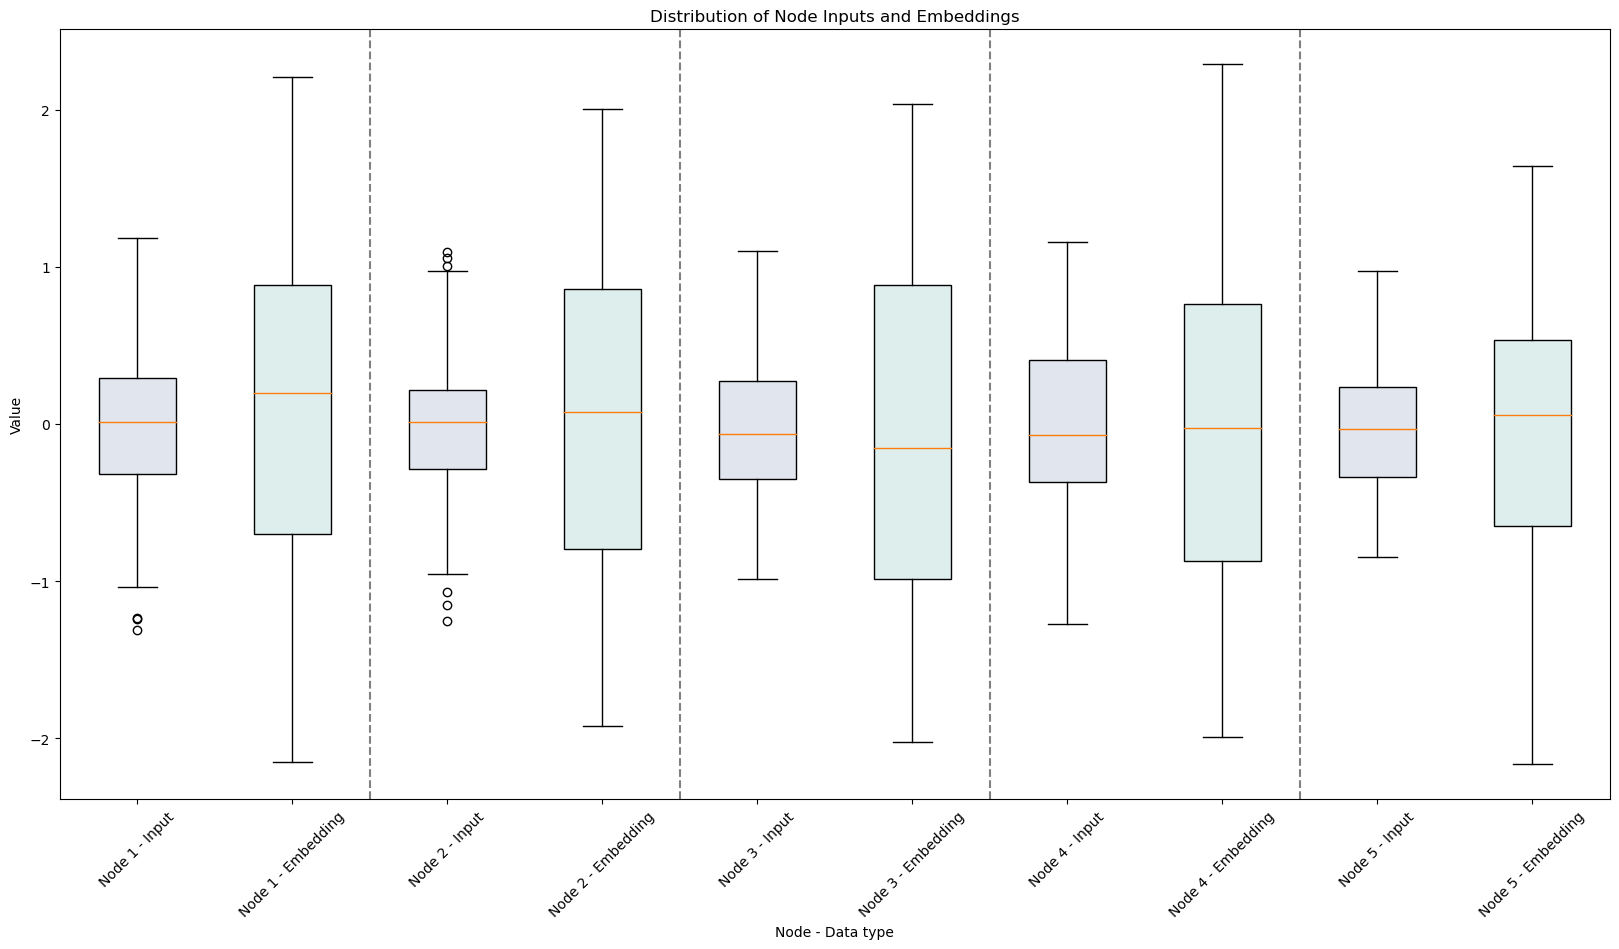

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming `inputs` and `embeddings` are your tensors
# inputs = torch.randn((5, 128))  # For example
# embeddings = torch.randn((5, 128))  # For example

# Convert tensors to numpy
_model = model
inputs_np = _model._init_embed(data).detach()[0, :, :].numpy()
embeddings_np = embeddings.numpy()

# Initialize the figure
fig, ax = plt.subplots(figsize=(20,10))

# Create a list to hold all the data for the boxplot
distributions = []

# For each node...
for i in range(inputs_np.shape[0]):
    # Append the data for each node's input and embedding
    distributions.append(inputs_np[i, :])
    distributions.append(embeddings_np[i, :])


cm = plt.cm.viridis(np.linspace(0, 1, embeddings_np.shape[0]))
colors = [cm[1], cm[2]] * (inputs_np.shape[0])
colors_with_alpha = [(r, g, b, 0.15) for r, g, b, _ in colors]  # set alpha to 0.6

# colors = np.repeat(plt.cm.viridis(np.linspace(0, 1, 2)), repeats=embeddings_np.shape[0], axis=0)

# Create the boxplot
bp = ax.boxplot(distributions, patch_artist=True)

# Change the color of each box
for patch, color in zip(bp['boxes'], colors_with_alpha):
    patch.set_edgecolor('black')
    patch.set_facecolor(color)
    # patch.set_alpha(0.15)
    patch.set_edgecolor('black')
    # patch.set_linewidth(3)

# Draw vertical lines to separate nodes
for i in range(2, 2*inputs_np.shape[0], 2):
    ax.axvline(i+0.5, color='grey', linestyle='--')

# Create the x-axis labels
xticklabels = []
for i in range(1, inputs_np.shape[0] + 1):
    xticklabels.append(f'Node {i} - Input')
    xticklabels.append(f'Node {i} - Embedding')
ax.set_xticklabels(xticklabels, rotation=45)

# Set the plot labels
ax.set_title('Distribution of Node Inputs and Embeddings')
ax.set_xlabel('Node - Data type')
ax.set_ylabel('Value')

plt.savefig(f"../images/evrp/boxplots_input_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

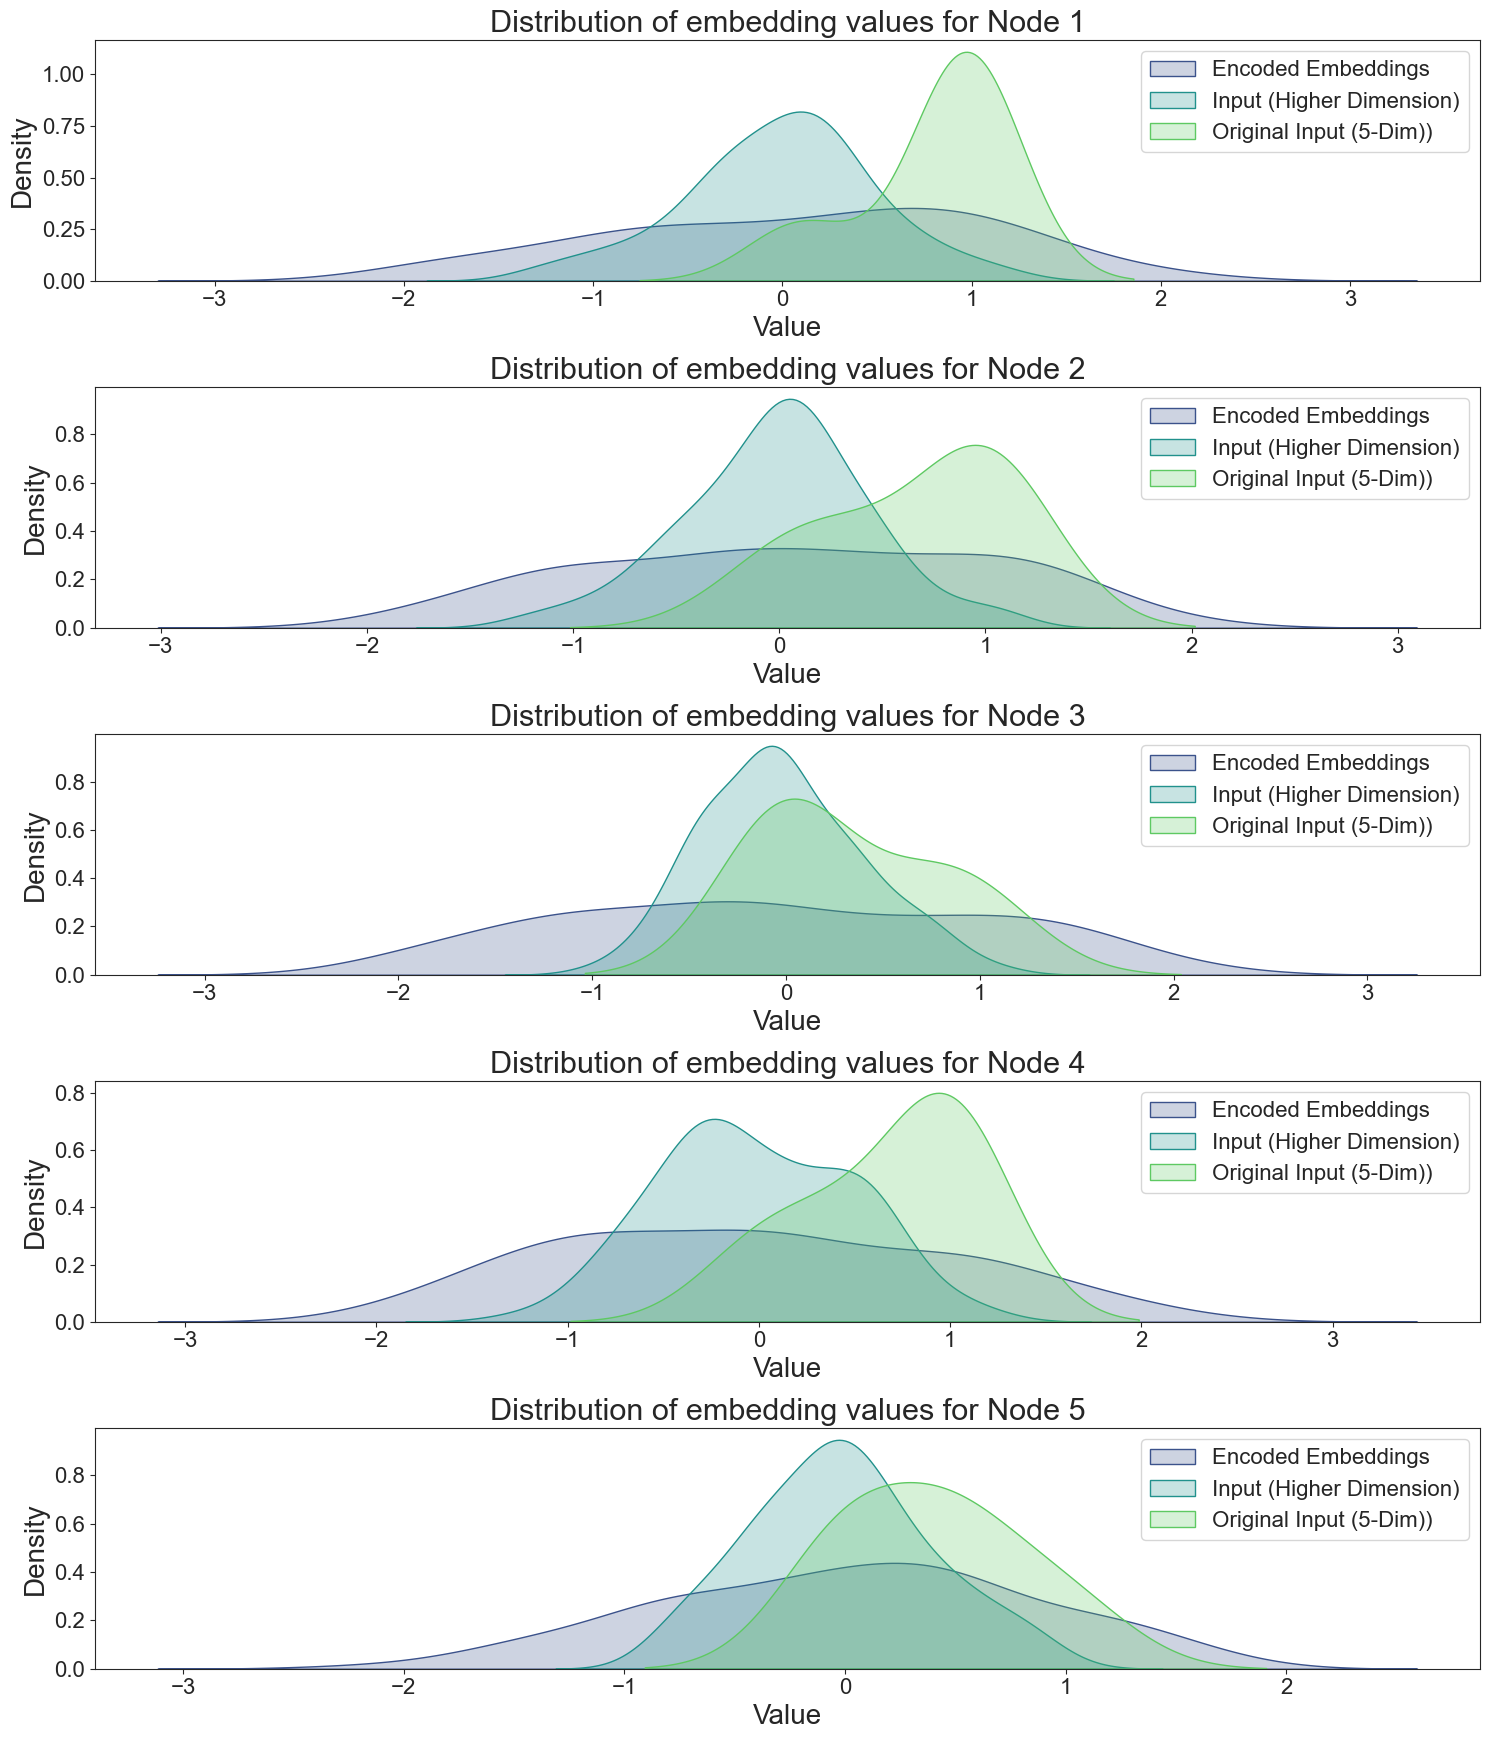

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

_model = model
input_np = _model._init_embed(data).detach()[0, :, :].numpy()
input_original_np = torch.cat((data["coords"], *(data[feat] for feat in _model.features)), -1)[0].numpy()
embeddings_np = embeddings.numpy()

# Create subplots
fig, axs = plt.subplots(embeddings_np.shape[0], 1, figsize=(15, 3.5*embeddings_np.shape[0]))


colors = plt.cm.viridis(np.linspace(0, 1, embeddings_np.shape[0]))
# For each node
for i in range(embeddings_np.shape[0]):
    # Create a KDE plot for each node's embedding
    sns.kdeplot(data=embeddings_np[i, :], ax=axs[i], fill=True, legend=True, color=colors[1], label='Encoded Embeddings')
    sns.kdeplot(data=input_np[i, :], ax=axs[i], fill=True, legend=True, color=colors[2], label='Input (Higher Dimension)')
    sns.kdeplot(data=input_original_np[i, :], ax=axs[i], fill=True, legend=True, color=colors[3], label='Original Input (5-Dim))')

    # Set title and labels
    axs[i].set_title(f'Distribution of embedding values for Node {i+1}', size=22)
    axs[i].set_xlabel('Value', size=20)
    axs[i].set_ylabel('Density', size=20)
    axs[i].tick_params(axis='both', labelsize=16)  
    axs[i].legend(fontsize=16) 

# Display plot
plt.tight_layout()
plt.savefig(f"../images/evrp/input_distributions_one_instance.png", dpi=300, bbox_inches='tight')
plt.show()

##### Heatmaps of the Attention Weights & Distance Matrix based on the Trailer Route

In [18]:
import seaborn as sns


In [19]:
# Function to set the color of labels
def set_label_colors(labels, colors):
    for label, color in zip(labels, colors):
        label.set_color(color)

def fix_naming(name):
    if name.split("_")[0] == "input":
        return "Original Input Nodes"
    return "Encoded Node Embeddings"

def plot_encoder_data(figures, ordered_nodes, node_colors, title="Heatmap Figures", trailer_idx=""):
    fig, axs = plt.subplots(1, len(figures), figsize=(20, 10))
    fig.suptitle(title, fontsize=24)

    # Create the heatmaps
    for index, (name, figure) in enumerate(figures.items()):
        ax = axs[index]
        ax.set_title(fix_naming(name), fontsize=22)

        # Create heatmap using seaborn
        cmap = plt.get_cmap('coolwarm')
        sns.heatmap(figure, cmap=cmap, annot=True, fmt=".2f", linewidths=.05, ax=ax,
                    xticklabels=ordered_nodes, yticklabels=ordered_nodes, cbar=False)

        # Set the xticklabels and yticklabels
        xticklabels = ax.get_xticklabels()
        yticklabels = ax.get_yticklabels()
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)

        set_label_colors(xticklabels, node_colors)
        set_label_colors(yticklabels, node_colors)

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Add colorbar for reference
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position of the colorbar
    fig.colorbar(ax.get_children()[0], cax=cbar_ax)
    
    plt.savefig(f"../images/evrp/distance_matrix_{example_name}_trailer{trailer_idx}_route.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


def plot_attention_weights(model):

    for layer_idx in range(model.n_encode_layers):
        attention_layer = model.encoder.layers[layer_idx][0].module
        # First instance of the batch
        att = attention_layer.get_attention_weights()[:, 0, :, :].detach().cpu().numpy()

        # Plot the attention weights
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle(f"Layer {layer_idx + 1} - Attention Weights", fontsize=24)

        for head in range(attention_layer.num_heads):
            ax = axs[head // 4, head % 4]
            # Use seaborn heatmap for the plot
            cmap = plt.get_cmap('coolwarm_r')
            sns.heatmap(att[head], annot=True, fmt=".2f", linewidths=.05, cmap=cmap, ax=ax, cbar=False)

            # Set axis labels and title
            ax.set_xlabel("To Node", fontsize=18)
            ax.set_ylabel("From Node", fontsize=18)
            ax.set_title(f"Attention Head {head + 1}", fontsize=20)
            ax.xaxis.set_tick_params(labelsize=16)
            ax.yaxis.set_tick_params(labelsize=16)

        # Adjust spacing between subplots
        plt.subplots_adjust(wspace=0.3, hspace=0.5)

        # Add colorbar for reference
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position of the colorbar

        fig.colorbar(ax.get_children()[0], cax=cbar_ax)
        cbar_ax.set_ylabel("Attention Weight", fontsize=20)

        # Convert the figure to a numpy array
        plt.savefig(f"../images/evrp/attention_weights_{example_name}_layer{layer_idx+1}.png", dpi=300, bbox_inches='tight')
        plt.show()

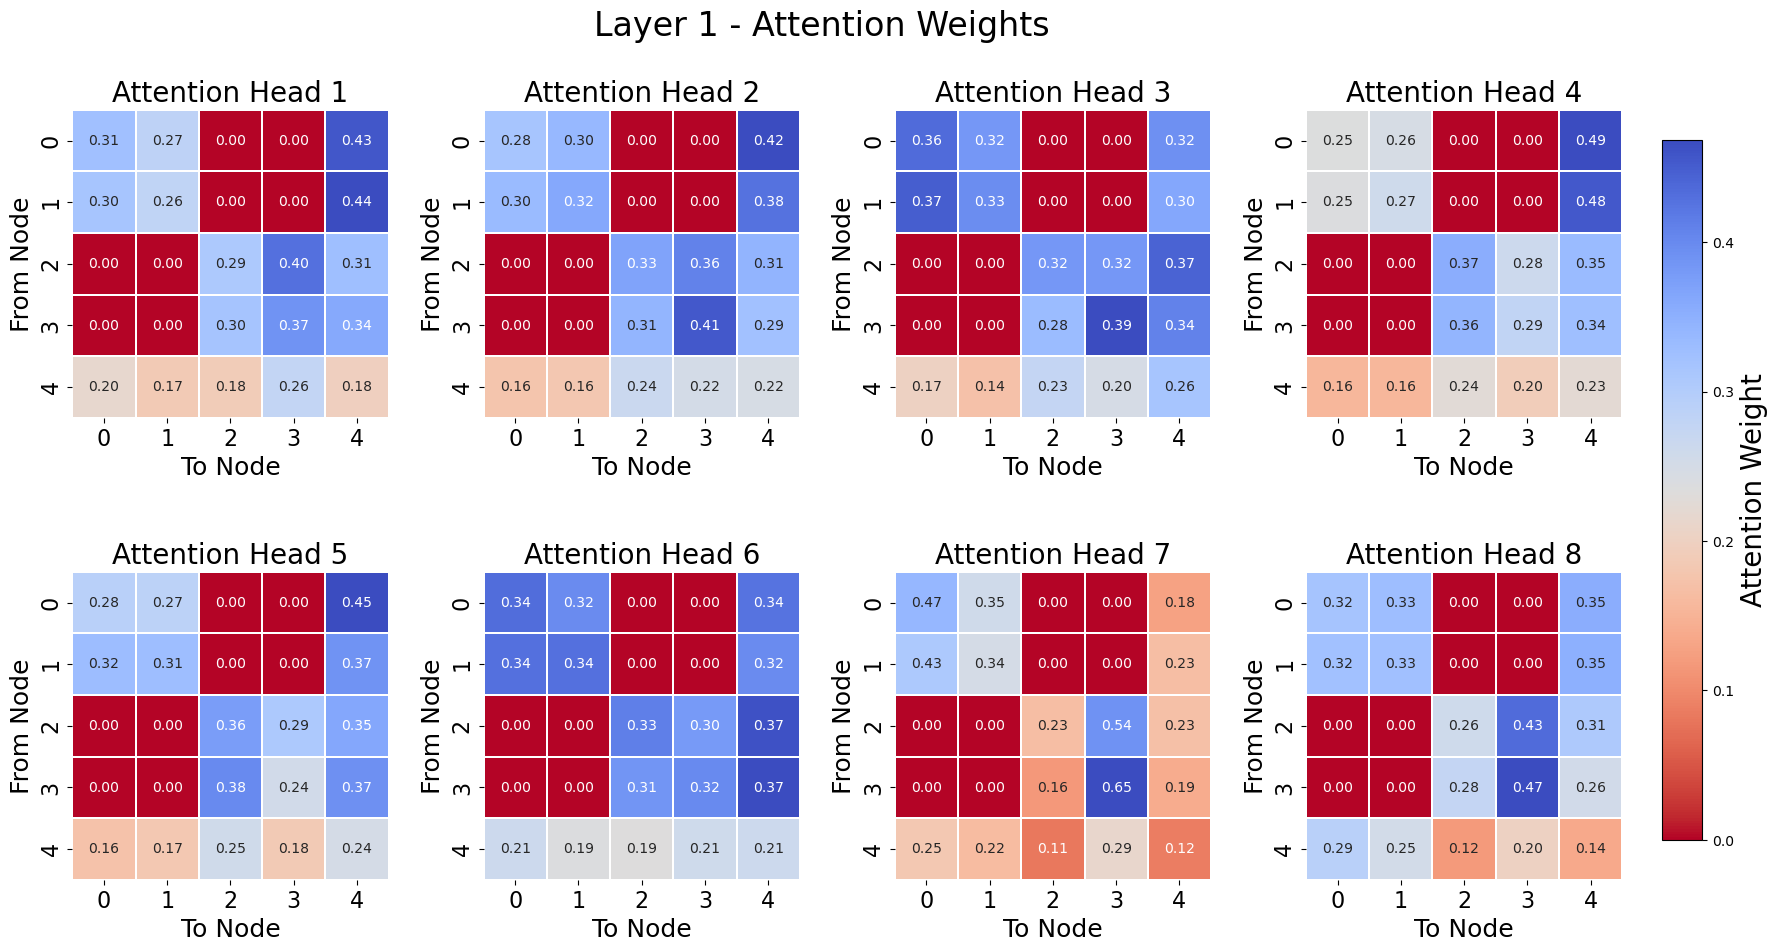

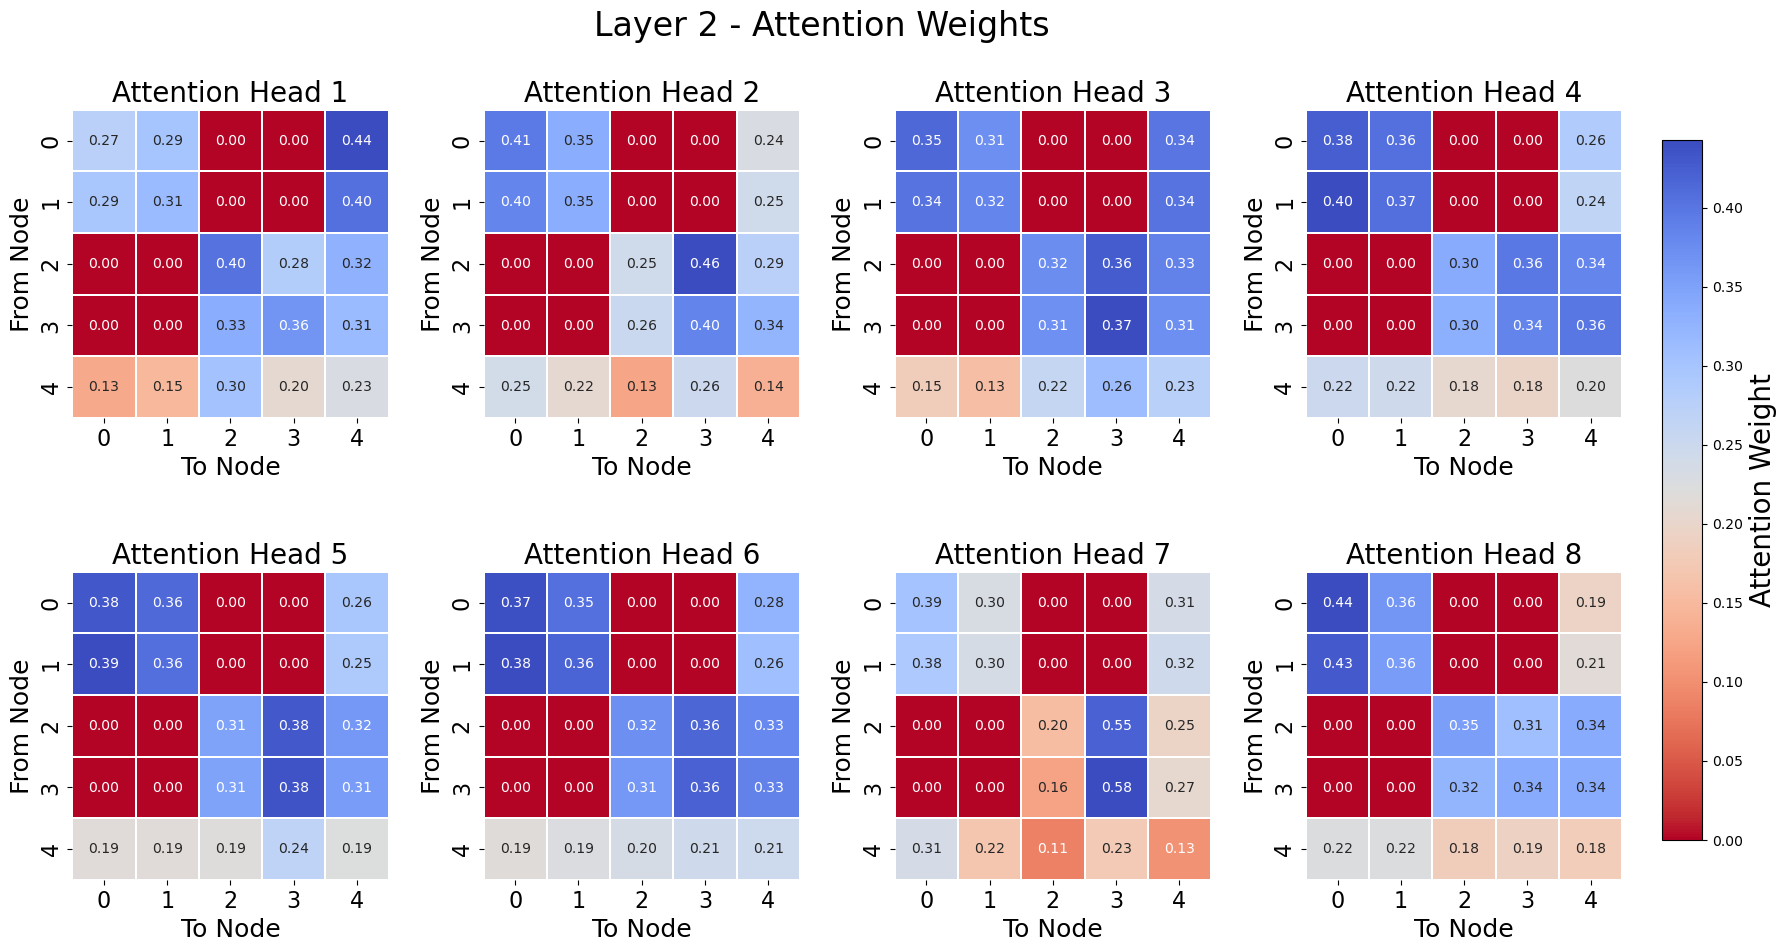

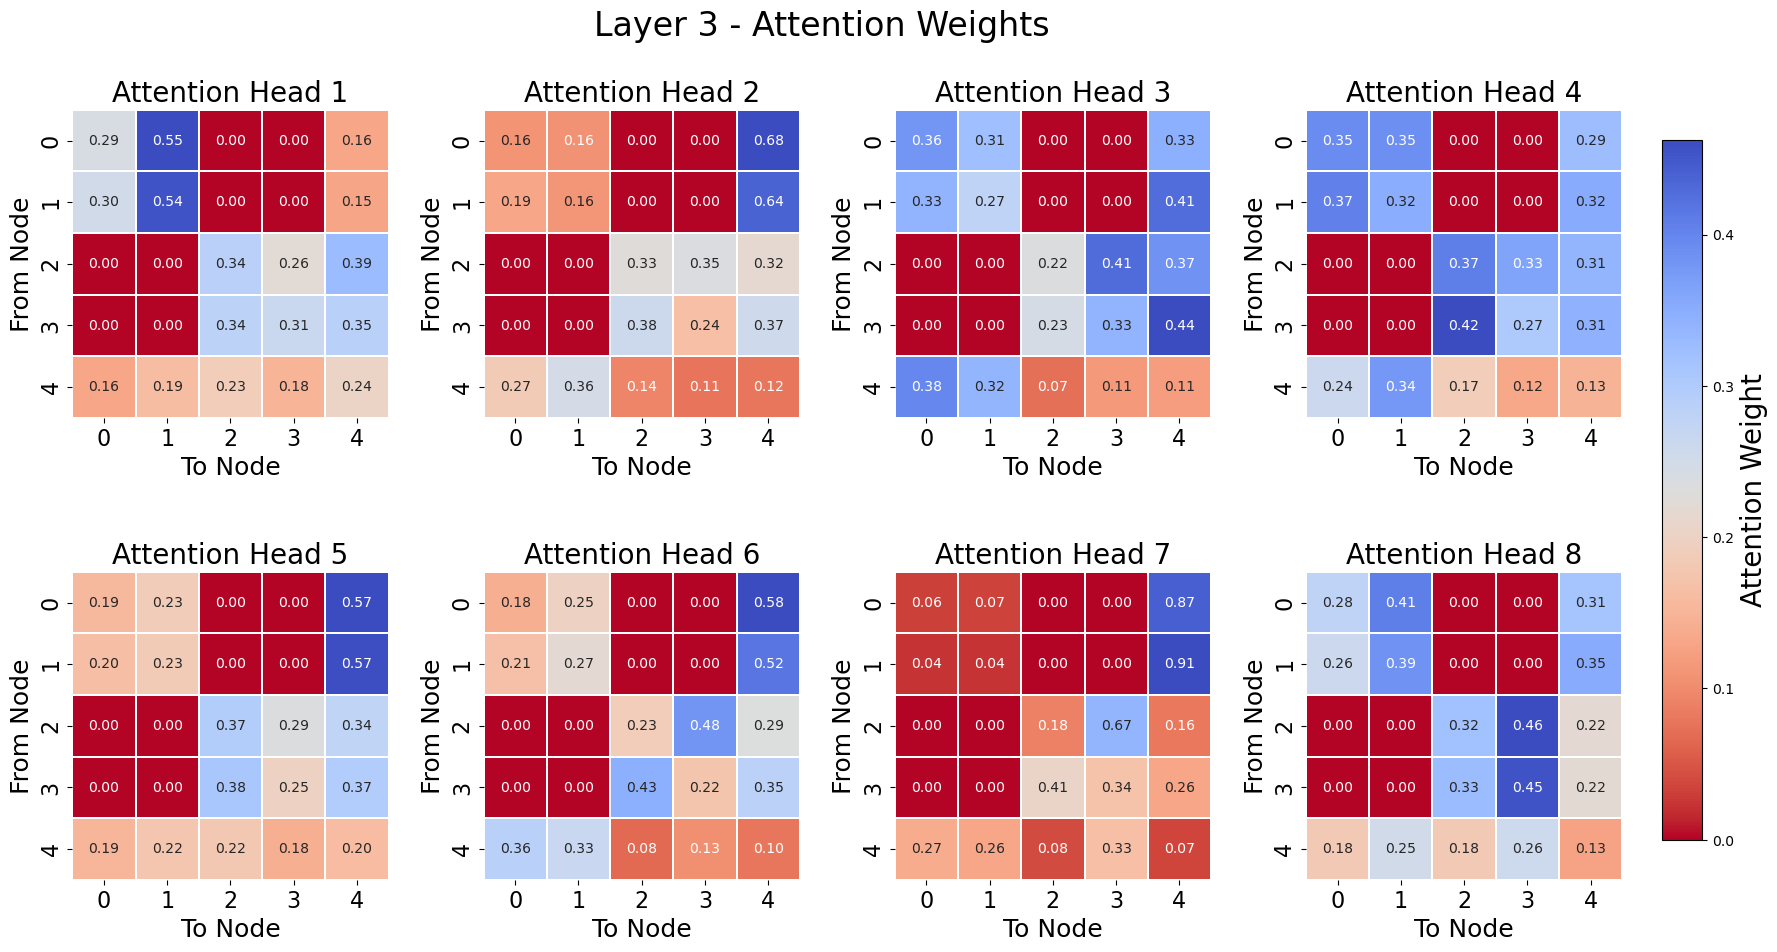

In [20]:
# Log the weights for each encoder layer
model_ = model   
plot_attention_weights(model_)

In [21]:
tours_trailers

{-1: [0, 1], 1: [1, 4, 3], 3: [1, 0], 0: [0, 4, 2], 2: [3, 4]}

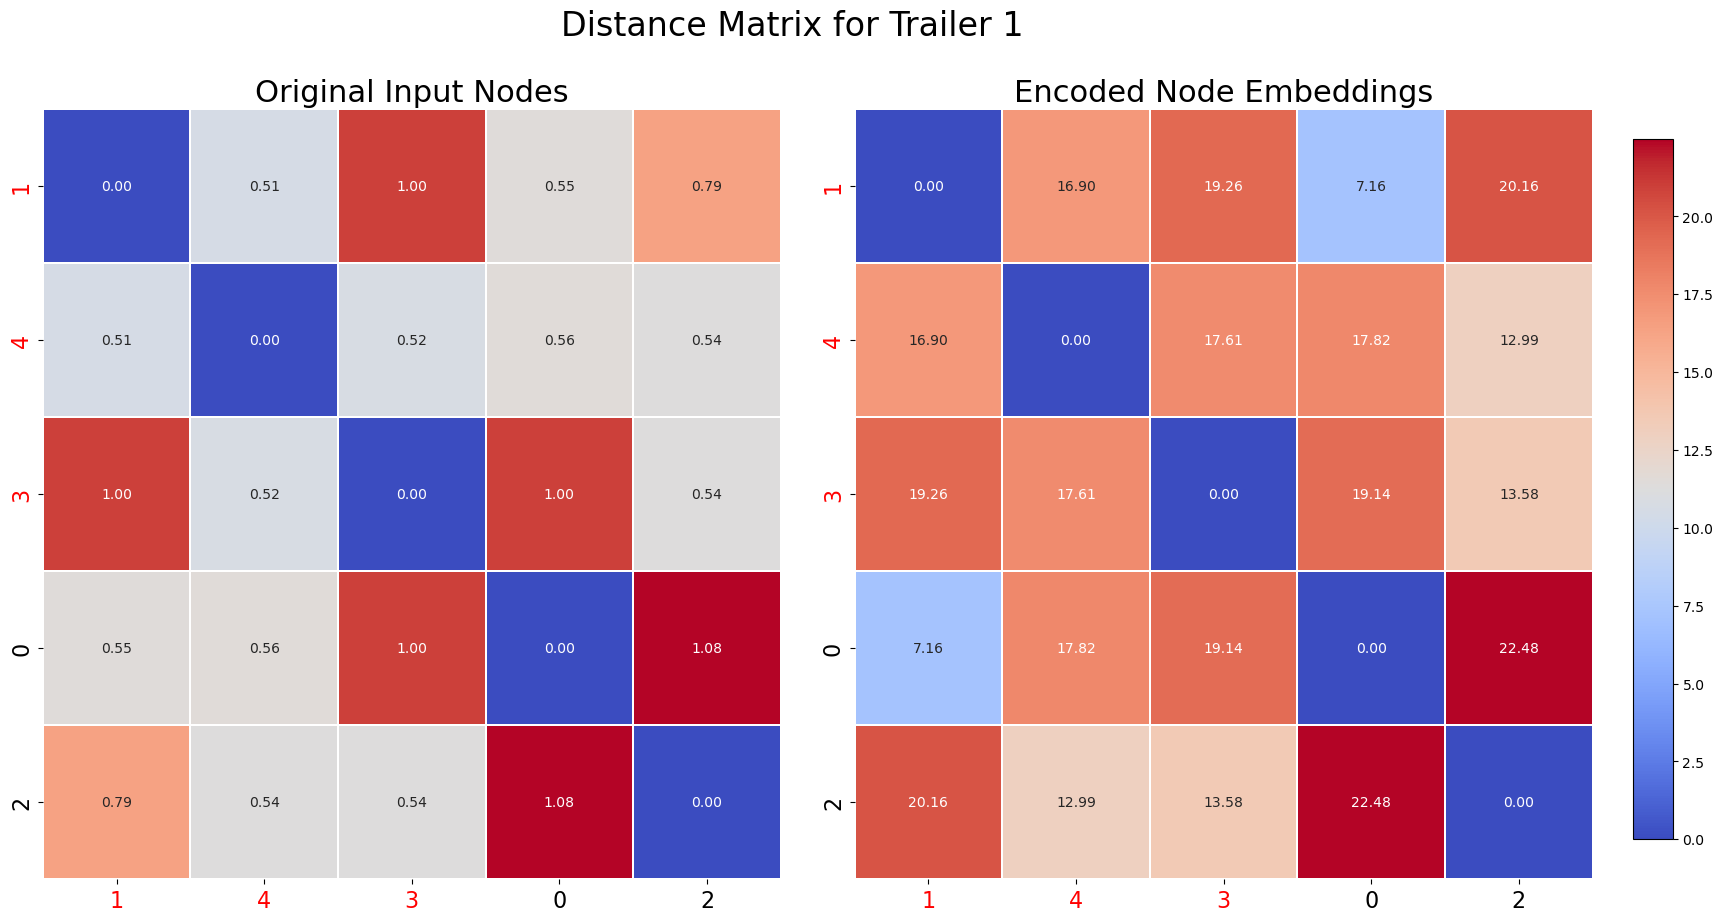

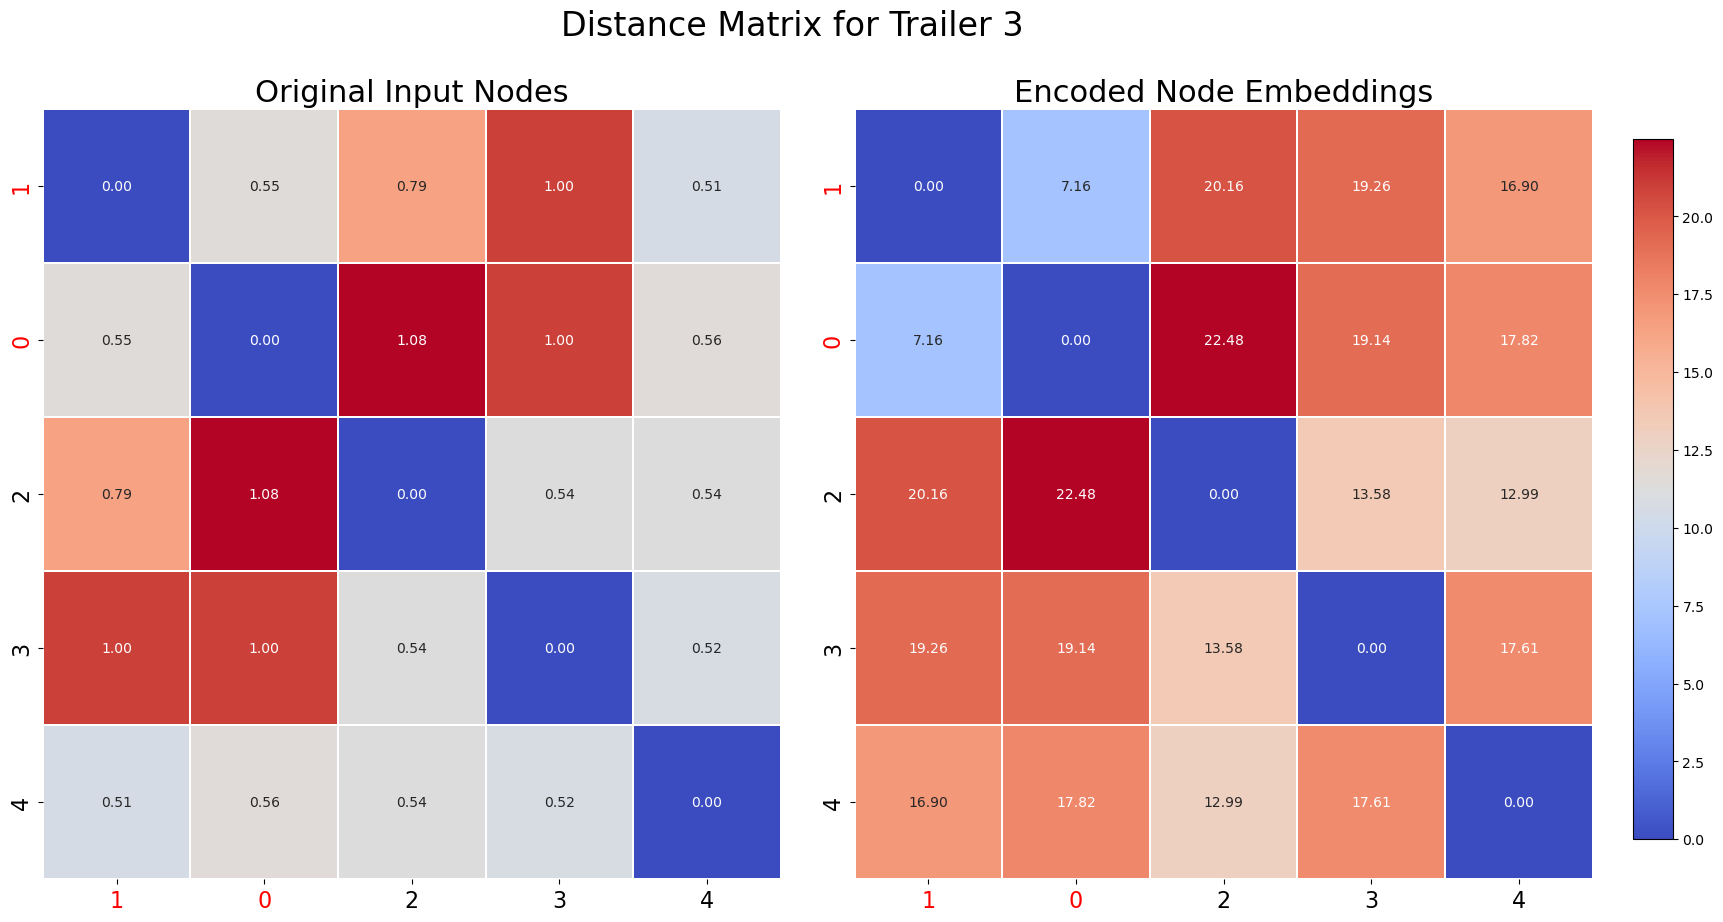

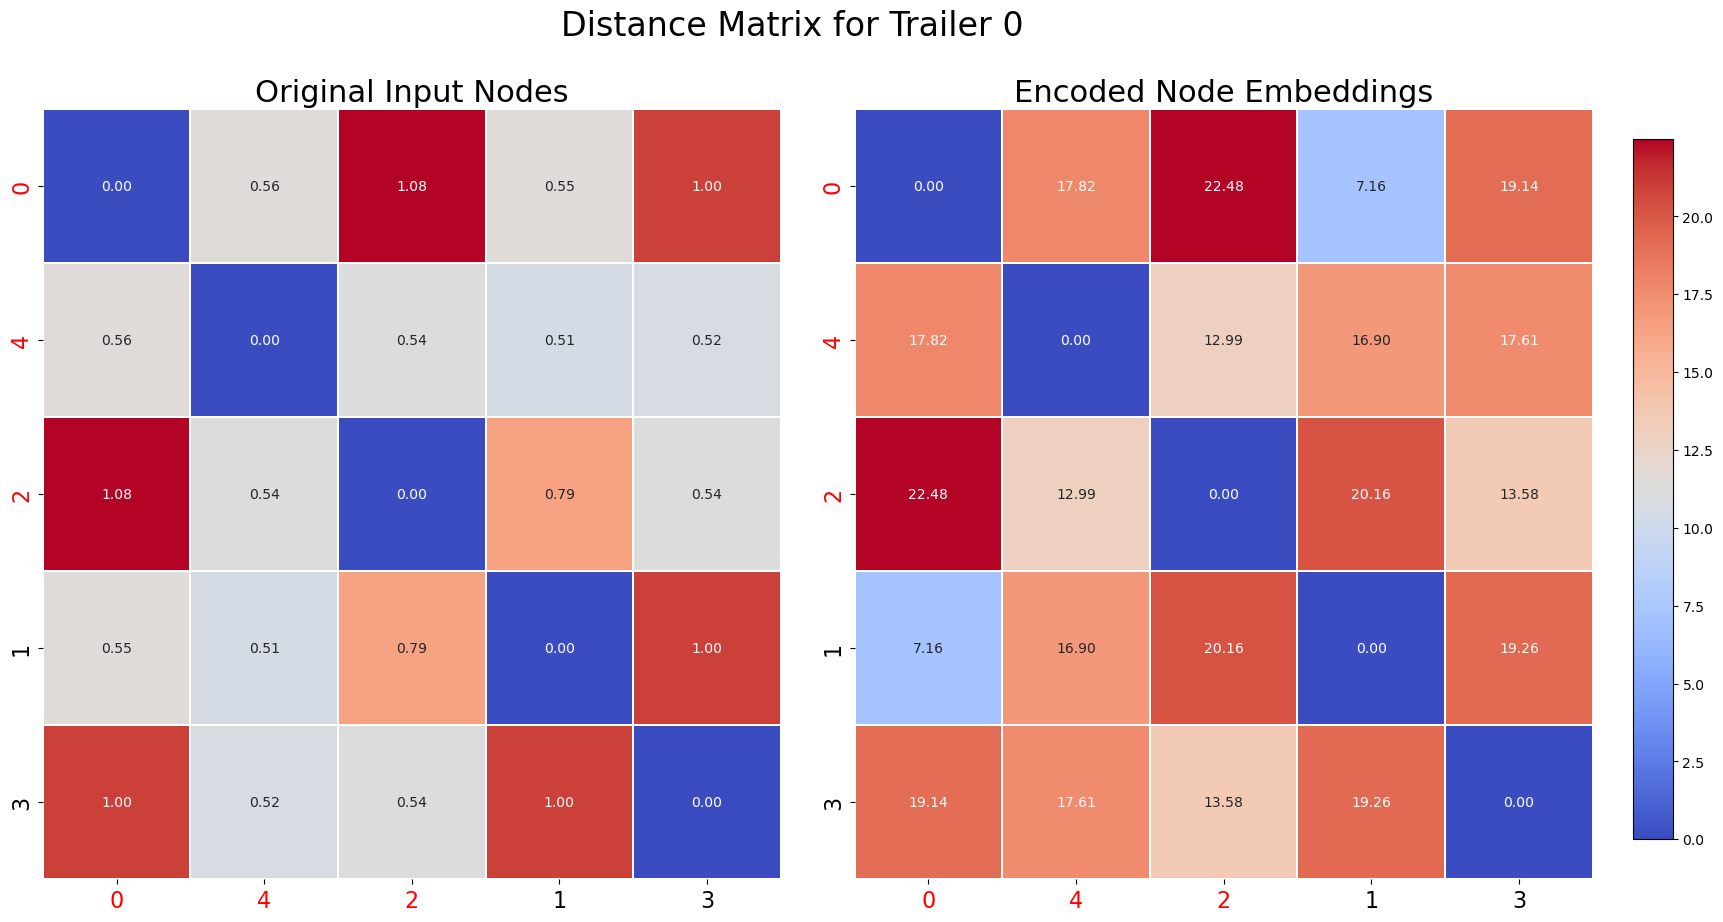

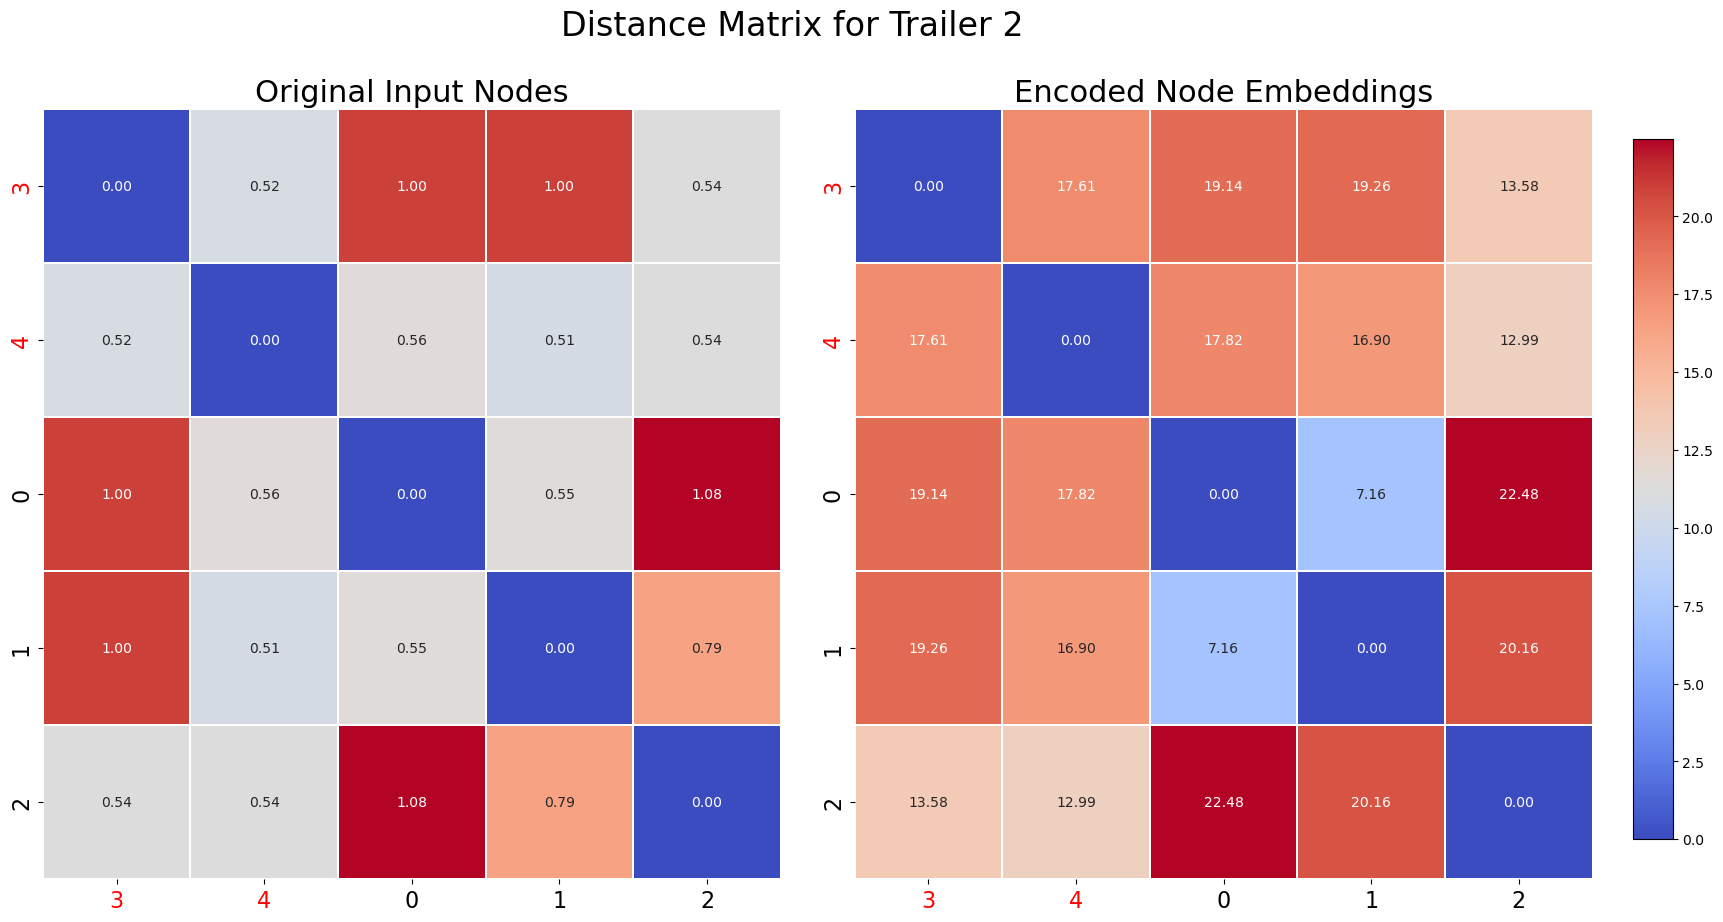

In [22]:
encoder_distance = {
    "input_distance": (
        input[:, None, :]-
        input[None, :, :]
    ).norm(p=2, dim=-1),
    "embedding_distance": (
        embeddings[:, None, :]
        - embeddings[None, :, :]
    ).norm(p=2, dim=-1),
}

for idx, tour in tours_trailers.items():
    if idx == -1 : continue
    ordered_nodes = tour + [node for node in range(embeddings.shape[0]) if node not in tour]
    ordered_figures = {k: v[ordered_nodes][:, ordered_nodes] for k, v in encoder_distance.items()}

    node_colors = ['red' if node in tour else 'black' for node in ordered_nodes]

    plot_encoder_data(ordered_figures, ordered_nodes, node_colors, title=f"Distance Matrix for Trailer {idx}", trailer_idx=idx)

##### Project down Embeddings to 2D

In [23]:
# TODO FIX Time to keep track per batch + fix the unfair costs per trucks*

In [44]:
cluster_labels

array([1, 1, 0, 2, 0], dtype=int32)

In [63]:
cluster_colors

[(0.127568, 0.566949, 0.550556, 1.0),
 (0.127568, 0.566949, 0.550556, 1.0),
 (0.267004, 0.004874, 0.329415, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.267004, 0.004874, 0.329415, 1.0)]

/Users/kleiofragkedaki/miniconda3/envs/RL_Thesis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/var/folders/gl/_6q874612pv_5g7n_b2_wbb40000gn/T/ipykernel_51299/3880038519.py:25: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



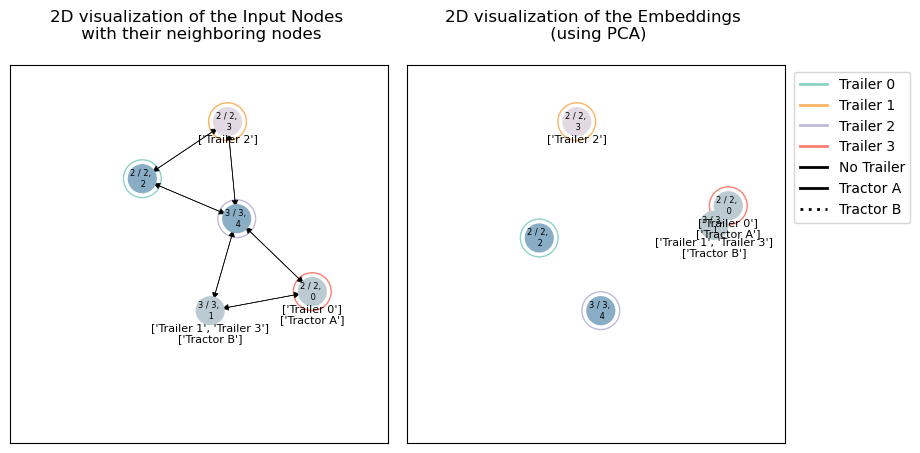

In [78]:
from src.graph.evrp_graph import EVRPGraph
# from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.colors as col


# Use t-SNE to reduce dimensionality to 2D for visualization
# proj = TSNE(n_components=2, perplexity=embeddings[0].shape[0] - 1)
proj = PCA(n_components=2)
embeddings_2d = proj.fit_transform(embeddings)
scaler = MinMaxScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)

# 1. Apply KMeans clustering on the embeddings
n_clusters = 3  # choose the number of clusters you'd like
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(embeddings_2d)

# Plot the 2D embeddings
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

colormap = plt.cm.get_cmap('twilight', 15)  # 'viridis' is just an example; choose any colormap you prefer.

graph_embeddings = EVRPGraph(
        coords=dict(enumerate(embeddings_2d)),
        num_chargers=dict(enumerate(data["num_chargers"][0].flatten().to(int).numpy())),
        trailers_locations=data["trailers_locations"][0].flatten().to(int).numpy(),
        trailers_destinations=data["trailers_destinations"][0].flatten().to(int).numpy(),
        trucks_locations=data["trucks_locations"][0].flatten().to(int).numpy(),
        
        num_trailers=data["trailers_destinations"][0].shape[0],
        num_trucks=data["trucks_locations"][0].shape[0],
        num_nodes=data["num_chargers"][0].shape[0]
    )

for node in range(5):
    cluster_node = cluster_labels[node]
    graph_embeddings.graph.nodes[node]['node_color'] = col.rgb2hex(colormap(cluster_node)) 


graph_embeddings.draw(ax=ax[1], with_labels=True)
ax[1].set_xlim([-0.7, 1.3])
ax[1].set_ylim([-0.7, 1.3])
ax[1].set_aspect('equal')
ax[1].set_title("2D visualization of the Embeddings \n (using PCA)\n")


# Plot the 2D original data with neighboring nodes
# fig, ax = plt.subplots()
graph_original = EVRPGraph(
    coords=dict(enumerate(input.numpy())),
    num_chargers=dict(enumerate(data["num_chargers"][0].flatten().to(int).numpy())),
    trailers_locations=data["trailers_locations"][0].flatten().to(int).numpy(),
    trailers_destinations=data["trailers_destinations"][0].flatten().to(int).numpy(),
    trucks_locations=data["trucks_locations"][0].flatten().to(int).numpy(),
    
    num_trailers=data["trailers_destinations"][0].shape[0],
    num_trucks=data["trucks_locations"][0].shape[0],
    num_nodes=data["num_chargers"][0].shape[0]
)

for node in range(5):
    cluster_node = cluster_labels[node]
    graph_original.graph.nodes[node]['node_color'] = col.rgb2hex(colormap(cluster_node)) 

graph_original.plot_neighbors(ax=ax[0], with_labels=False)
ax[0].set_xlim([-0.7, 1.3])
ax[0].set_ylim([-0.7, 1.3])
ax[0].set_title("2D visualization of the Input Nodes \n with their neighboring nodes\n")
ax[0].set_aspect('equal')

plt.savefig(f"../images/evrp/2D_representation_embeddings_graph_{example_name}.png", dpi=300, bbox_inches='tight')
plt.show()

##### Other plots

In [25]:
distance_matrix = (input[:, None, :]-
        input[None, :, :]
    ).norm(p=2, dim=-1)

/var/folders/gl/_6q874612pv_5g7n_b2_wbb40000gn/T/ipykernel_51299/3869603152.py:8: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



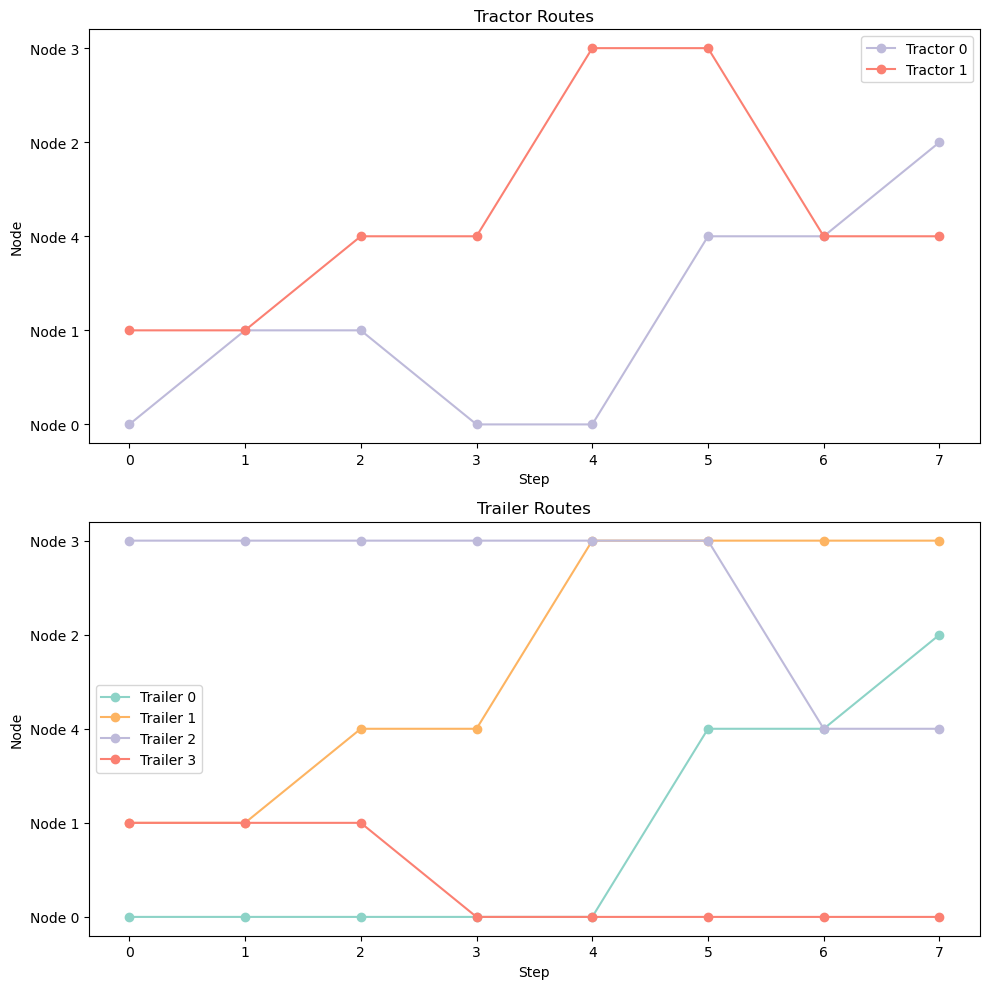

In [26]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
# from sklearn.manifold import MDS

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Apply hierarchical clustering (using 'average' linkage method)
Z = linkage(distance_matrix, method='average')
# Get the order of the nodes
node_positions = leaves_list(Z)

# embedding = MDS(n_components=1, dissimilarity='precomputed', random_state=0)
# node_positions = embedding.fit_transform(distance_matrix).ravel()

# Map node positions to labels
node_labels = [f'Node {i}' for i in node_positions]
node_position_to_label = {pos: label for pos, label in zip(node_positions, node_labels)}

colors = get_trailer_colors(len(tours_trailers_with_time)+1)

# Plot truck routes
for truck_idx, truck_route in tours_trucks_with_time.items():
    # y_values = [node_positions[node] for node in truck_route]
    y_values = [node_positions.tolist().index(node) for node in truck_route]
    ax[0].plot(y_values,  marker='o',label=f'Tractor {truck_idx}', color=colors[truck_idx+2])
    
# Plot trailer routes
for trailer_idx, trailer_route in tours_trailers_with_time.items():
    # y_values = [node_positions[node] for node in trailer_route]
    y_values = [node_positions.tolist().index(node) for node in trailer_route]
    ax[1].plot(y_values,  marker='o', label=f'Trailer {trailer_idx}', color=colors[trailer_idx])

# Set plot labels
ax[0].set_title('Tractor Routes')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Node')
ax[0].legend()
# ax[0].set_yticks(node_positions)
ax[0].set_yticks(range(len(node_positions)))
ax[0].set_yticklabels(node_labels)

ax[1].set_title('Trailer Routes')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Node')
ax[1].legend()
# ax[0].set_yticks(node_positions)
ax[1].set_yticks(range(len(node_positions)))
ax[1].set_yticklabels(node_labels)

plt.tight_layout()
plt.savefig(f"../images/evrp/truck_routes_{example_name}.png", dpi=300, bbox_inches='tight')
plt.show()

In [27]:
def find_movement_windows(tours):
    movement_windows = {}
    for trailer_id, locations in tours.items():
        windows = []
        last_location = locations[0]
        for i in range(1, len(locations)):
            if locations[i] != last_location:
                windows.append((i-1, i))
                last_location = locations[i]
        movement_windows[trailer_id] = windows
    return movement_windows

/var/folders/gl/_6q874612pv_5g7n_b2_wbb40000gn/T/ipykernel_51299/2768428264.py:10: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



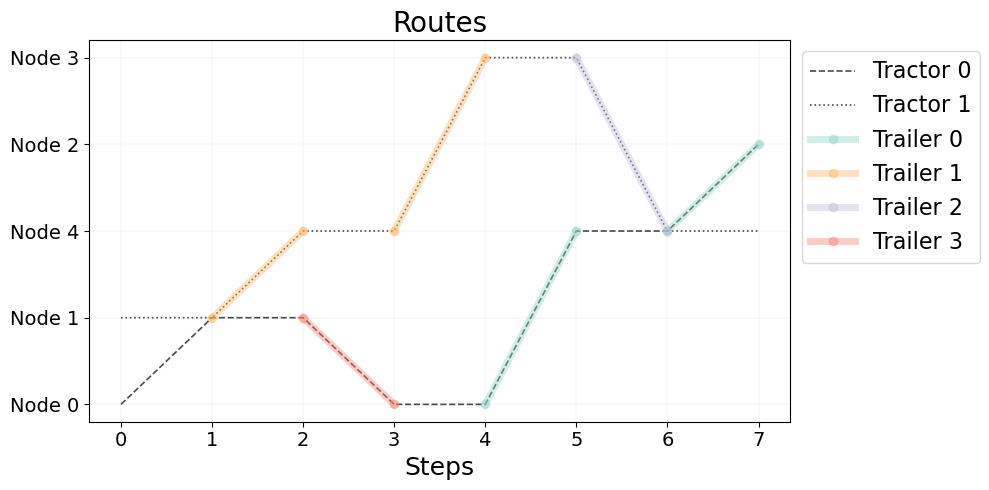

In [28]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

fig, ax = plt.subplots(figsize=(10, 5))

# Define linestyles
linestyles = ['dashed', 'dotted', 'loosely dotted', 'solid']

# Apply hierarchical clustering (using 'average' linkage method)
Z = linkage(distance_matrix, method='average')
# Get the order of the nodes
node_positions = leaves_list(Z)

# Map node positions to labels
node_labels = [f'Node {i}' for i in node_positions]
node_position_to_label = {pos: label for pos, label in zip(node_positions, node_labels)}

colors = get_trailer_colors(len(tours_trailers_with_time)+1)

# Plot all points for trucks and trailers
for truck_idx, truck_route in enumerate(tours_trucks_with_time.values()):
    y_values = [node_positions.tolist().index(node) for node in truck_route]
    # ax.scatter(range(len(y_values)), [x-0.15 for x in y_values], color='black', marker='o', alpha=0.9)
    ax.plot(y_values, linestyle=linestyles[truck_idx % len(linestyles)], color='black',alpha=0.7, label=f'Tractor {truck_idx}', linewidth=1.2)

time_windows = find_movement_windows(tours_trailers_with_time)
# Plot trailer routes within time windows
for trailer_idx, trailer_route in enumerate(tours_trailers_with_time.values()):
    for window_start, window_end in time_windows[trailer_idx]:
        y_values_window = [node_positions.tolist().index(node) for node in trailer_route[window_start:window_end+1]]
        ax.plot([x for x in range(window_start, window_end+1)], y_values_window, linestyle='-', marker="o", linewidth=5, color=colors[trailer_idx], alpha=0.4, label=f'Trailer {trailer_idx}')

# Set plot labels
ax.set_title('Routes', fontdict={"fontsize":"20"})
ax.set_xlabel('Steps', fontdict={"fontsize":"18"})
# ax.set_ylabel('Node', fontdict={"fontsize":"18"})

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), bbox_to_anchor=(1, 1), fontsize=16)

ax.set_yticks(range(len(node_positions)))
ax.set_yticklabels(node_labels, fontsize=14)

# add grid
ax.grid(True, linewidth=0.1)
# set xticks to be integers
num_steps = len(next(iter(tours_trucks_with_time.values())))
ax.set_xticks(np.arange(num_steps))
ax.set_xticklabels(np.arange(num_steps), fontsize=14)

plt.tight_layout()
plt.savefig(f"../images/evrp/route_{example_name}.png", dpi=300, bbox_inches='tight')
plt.show()

##### QQ-plots

In [29]:
# env = EVRP
# val_dataset = env.make_dataset(
#         size=5,
#         num_samples=1,
#         num_trucks=2,
#         num_trailers=4,
#         truck_names=None,
#         display_graphs=3,
#         r_threshold=0.6
#     )

# # Need a dataloader to batch instances
# dataloader = DataLoader(val_dataset, batch_size=1, collate_fn=collate_fn)

# # Make var works for dicts
# batch_multiple_data = next(iter(dataloader))

# # Set eval mode
# model.eval()
# model.set_decode_type('greedy')

In [30]:
batch_multiple_data = batch

In [31]:
_model = model
input_multiple_data_5_dim = torch.cat((batch_multiple_data[0]["coords"], *(batch_multiple_data[0][feat] for feat in _model.features)), -1).detach()
input_multiple_data_high_dim = _model._init_embed(batch_multiple_data[0]).detach()
embeddings_multiple_data = _model.encoder_data["embeddings"]
# _model.encoder(input_multiple_data_high_dim).detach()

In [32]:
distances_between_inputs = (input_multiple_data_5_dim[:, None, :] - input_multiple_data_5_dim[:, :, None]).norm(p=2, dim=-1).reshape(-1)

In [33]:
distances_between_outputs = (embeddings_multiple_data[:, None, :] - embeddings_multiple_data[:, :, None]).norm(p=2, dim=-1).reshape(-1)
distances_between_outputs.shape

torch.Size([25])

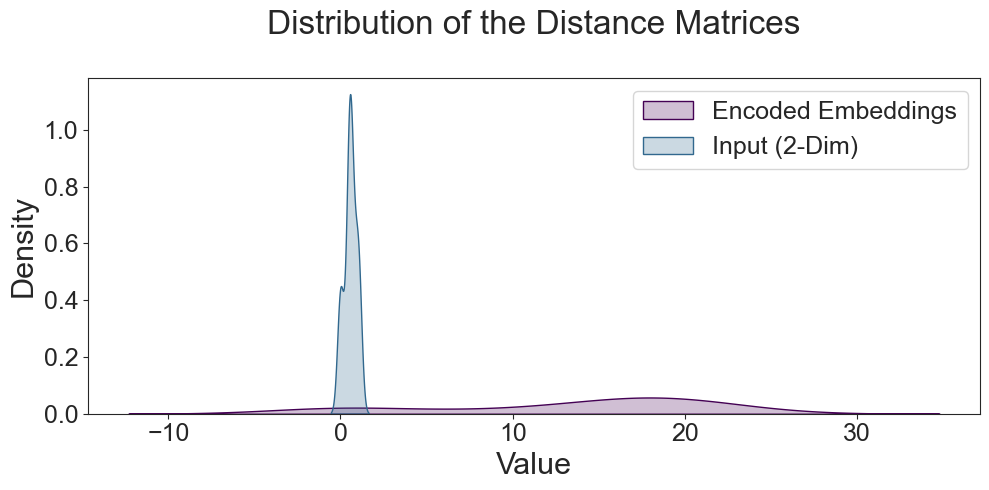

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

input_np = encoder_distance["input_distance"].flatten()
embeddings_np = encoder_distance["embedding_distance"].flatten()

# Create a single subplot
fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.viridis(np.linspace(0, 1, 4))  # Adjusted to have 4 colors

# Plot KDEs for the data
sns.kdeplot(data=embeddings_np, ax=ax, fill=True, legend=True, color=colors[0], label='Encoded Embeddings')
sns.kdeplot(data=input_np, ax=ax, fill=True, legend=True, color=colors[1], label='Input (2-Dim)')

# Set title and labels
ax.set_title(f'Distribution of the Distance Matrices\n', size=24)
ax.set_xlabel('Value', size=22)
ax.set_ylabel('Density', size=22)
ax.tick_params(axis='both', labelsize=18)  
ax.legend(fontsize=18) 

# Display plot
plt.tight_layout()
plt.savefig(f"../images/evrp/distances_distribution_evrp.png", dpi=300, bbox_inches='tight')
plt.show()

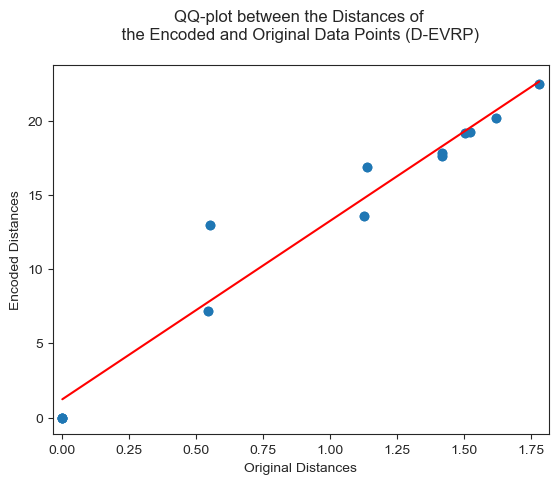

In [85]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples

# Assume you have dataset1 and dataset2

pp_x = sm.ProbPlot(distances_between_inputs)
pp_y = sm.ProbPlot(distances_between_outputs)

# Create the QQ plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Generate QQ plot
plt.title("QQ-plot between the Distances of \n the Encoded and Original Data Points (D-EVRP) \n")
qq = qqplot_2samples(pp_x, pp_y, line='r', ax=ax, xlabel="Original Distances", ylabel="Encoded Distances")
# Show the plot
plt.savefig(f"../images/evrp/qq_plot_evrp.png", dpi=300, bbox_inches='tight')
plt.show()

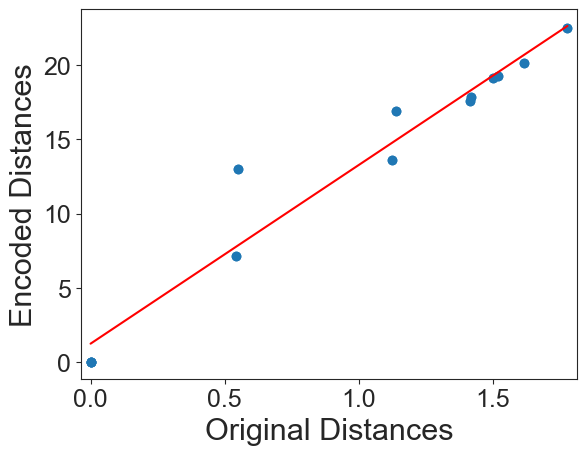

In [84]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the existence of distances_between_inputs and distances_between_outputs
pp_x = sm.ProbPlot(distances_between_inputs)
pp_y = sm.ProbPlot(distances_between_outputs)

# Set the Seaborn style
sns.set_style("ticks")
# sns.set_context("notebook", font_scale=1.5)  # Adjust the font_scale value for your needs

# Create the QQ plot
fig, ax = plt.subplots()

# Generate QQ plot
qq = sm.qqplot_2samples(pp_x, pp_y, line='r', ax=ax)

# plt.title("QQ-plot between the Distances of \n the Encoded and Original Data Points \n", size=24)
ax.set_xlabel("Original Distances", fontsize=22)
ax.set_ylabel("Encoded Distances", fontsize=22)
ax.tick_params(axis='both', labelsize=18)

# Show the plot
plt.savefig(f"../images/evrp/qq_plot_evrp.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [86]:
from scipy.interpolate import interp1d

# Get the actual points on the QQ plot
actual_points = qq.axes[0].lines[0].get_xydata()

# Get the regression line
reg_line = qq.axes[0].lines[1].get_xydata()

f = interp1d(reg_line[:, 0], reg_line[:, 1], kind='linear')
regression_y = f(actual_points[:, 0])

# Calculate the differences 
difference = actual_points - np.column_stack((reg_line[:, 0], regression_y))
difference2 = actual_points - reg_line

distance = torch.tensor(difference).norm(p=2, dim=-1)
distance2 = torch.tensor(difference2).norm(p=2, dim=-1)

# Print differences?
print("Mean: ", distance.mean().item(), "Meadian: ", distance.median().item(),  "Std: ", distance.std().item())
print(distance2.mean(), distance2.median())

Mean:  1.1399448493561297 Meadian:  0.6708610602134506 Std:  1.3162049671965628
tensor(1.1399, dtype=torch.float64) tensor(0.6709, dtype=torch.float64)
